In [5]:
# Preemptive command to configure Speasy to use specific SSL certificates in the Virtual Environment
import os, certifi

os.environ["SSL_CERT_FILE"] = certifi.where()
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

In [6]:
# Libraries Set Up
import speasy as spz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
from matplotlib import colors
import spiceypy as spice
from datetime import datetime, timezone

In [7]:
# (1) Useful Function for easily exploring the AMDA datatree:
def visualizer(folder):
        """
        Explore and display accessible attributes from a Speasy tree object.
    
        This utility function iterates through the attributes of a Speasy
        directory-like object, filtering out private/internal attributes
        (identified by leading underscores) to display only publicly
        accessible data entries. Designed for navigating hierarchical
        structures in planetary science databases.
    
        Parameters
        ----------
        folder : object
            A Speasy tree object containing dataset metadata attributes

        Returns
        -------
        str
            The last attribute name processed (primarily for internal use)
        """
        for voice in dir(folder):
            if not voice.startswith("_"): 
                print(voice)
        return voice
# (2) Useful Function for easily exploring instruments inside Voyager 2 payload:
def organizer1():
    catalogue= dir(voy2)
    payload=[]
    for instrument in catalogue:
        if (not instrument.startswith("__")) and any(char.isupper() for char in instrument):
            payload.append(instrument)
        else:
            exit
    return payload
# (3) Function to simplify access to data from speasy::
def veryspeasy(folder,startdata,endata):
    start=str(startdata[2])+"-"+str(startdata[1])+"-"+str(startdata[0])
    end=str(endata[2])+"-"+str(endata[1])+"-"+str(endata[0])
    data_of_folder=spz.get_data(folder,start,end)
    df_list=[]
    for v in data_of_folder.variables:
        v_data=data_of_folder.variables[v]
        df=v_data.to_dataframe()
        df_list.append(df)
    DF=pd.concat(df_list,axis=1)
    return DF

In [8]:
# Remove unuseful data providers from speasy for a better import procedure:
spz.config.core.disabled_providers.set('sscweb,cdaweb,csa') 
# Access the datatree:
amda_tree = spz.inventories.tree.amda
# Employ the visualizer function to navigate through datatree elements:
print("Entries aviable in the AMDA datatree:")
visualizer(amda_tree)
print("\n")

Entries aviable in the AMDA datatree:
Catalogs
Parameters
TimeTables
build_date
clear
spz_name
spz_provider
spz_type
spz_uid




In [9]:
# Via autocompletion, navigate through the sections until reaching the Voyager 2 mission of interest
print("Catalog of missions for which information is available:")
visualizer(amda_tree.Parameters)
print("\n")

Catalog of missions for which information is available:
ACE
AMPTE
ARTEMIS
Astronomical_Objects_Ephemerides
BepiColombo
Cassini
Cluster
DSCOVR
Double_Star
EISCAT
Freja
Galileo
Geotail
Giotto
HelioSwarm
Helios
ICE
IMP
ISEE
Indices
Interball
JASON3
JUICE
Juno
MAVEN
MESSENGER
MEX
MGS
MMS
Magnetic_Field_Models
Mariner_10
OMNI
PSP
PVO
Phobos_2
Pioneer
Planets_Properties
Polar
Rosetta
SOHO
STEREO
SolarOrbiter
Solar_Irradiance
Solar_Wind_Propagation_Models
Swarm
THEMIS
Ulysses
VEX
Voyager
Wind
clear
desc
is_public
name
spz_name
spz_provider
spz_type
spz_uid
xmlid




In [10]:
# Upon identification of the relevant "subfolder" concerning the Voyager 2 mission, the content is stored in a new variable
voy2=amda_tree.Parameters.Voyager.Voyager_2
# At this stage, following the identification of the relevant branch, the onboard instrumentation list is extracted via the specific 
# organizer1 function:
payload=organizer1()
print(payload)

['CRS', 'Ephemeris', 'LECP', 'MAG', 'PLS', 'PWS', 'spaseId']


In [11]:
# The payload variable now contains all instruments aboard the Voyager 2 spacecraft, accessible via the speasy library. 
# For the project purposes, attention will now focus on PLS and specifically on data related to the Uranus flyby:
pls=voy2.PLS.flyby_uranus
print("Information contained in PLS pertaining to the Uranus flyby:")
visualizer(pls)
print("\n")

Information contained in PLS pertaining to the Uranus flyby:
clear
is_public
name
spz_name
spz_provider
spz_type
spz_uid
vo2_pls_uraelebr
vo2_pls_uraelefit
vo2_pls_uraionbr
vo2_pls_uraionfit
xmlid




In [12]:
# At this stage, the PLS entry contains several datasets:
# - The first two entries, labeled 'vo2_pls_uraele', refer to measurements concerning electrons;
# - The last two entries, labeled 'vo2_pls_uraion', refer to measurements concerning ions.
# The designations 'br' and 'fit' stand for 'browse' and 'fit' respectively. Data of the 'browse' type are useful for rapid dataset 
# visualization, anomaly identification, and filtering of time intervals of interest; whereas 'fit' type data are preferable for accurate 
# quantitative analysis or publication of reliable results. The objective of this work focuses on the representation of trustworthy 
# scientific imagery, therefore only the latter type will be utilized.
e_moments=pls.vo2_pls_uraelefit
i_moments=pls.vo2_pls_uraionfit
# Having finally reached the variables of interest, it is now necessary to extract their values for subsequent manipulation. 
# While standard data access via speasy is convenient within the working environment, I found it to be considerably hard and complex. 
# This rationale led to the creation of the veryspeasy function, designed to render data extraction more convenient and efficient.
DF_electro=veryspeasy(e_moments,[24,1,1986],[25,1,1986])
DF_ion=veryspeasy(i_moments,[24,1,1986],[25,1,1986])

In [13]:
# Define the cleaner function to verify the presence of any duplicate indices within the extracted dataframes and delete them to ensure 
# data integrity:
def cleaner(dataframe):
    """
    Clean DataFrame by removing duplicate temporal indices while preserving data integrity.
    
    Scans the DataFrame index for duplicate timestamps and removes redundant entries,
    keeping only the first occurrence of each duplicate. This ensures temporal
    uniqueness required for time-series analysis of plasma measurements.
    
    Parameters
    ----------
    dataframe : pandas.DataFrame
        Input DataFrame with DateTimeIndex to be cleaned
        
    Returns
    -------
    pandas.DataFrame
        Cleaned DataFrame with unique temporal indices
        
    Notes
    -----
    Essential for preprocessing spacecraft data where duplicate timestamps
    may occur due to data transmission or recording artifacts
    Maintains the first occurrence of duplicates as the authoritative value
    """
    if not dataframe.index.is_unique:
        dataframe = dataframe[~dataframe.index.duplicated(keep='first')]
        print('Duplicate indices detected. The database has been processed and redundant data has been removed') 
        return dataframe
    else:
        print('No duplicate indices detected')
# Employ cleaner function on datasets:
DF_electro=cleaner(DF_electro)
DF_ion=cleaner(DF_ion)

Duplicate indices detected. The database has been processed and redundant data has been removed
Duplicate indices detected. The database has been processed and redundant data has been removed


In [14]:
# Having obtained information regarding the various quantities measured by PLS, in order to produce representations capable of correlating 
# these data with the spacecraft's spatial coordinates at precise time instances, the SpeasyPy library is employed. 
# This library is capable of analytically generating the position of requested objects. Subsequently, the recently extracted dataframes 
# will be implemented to obtain new columns containing the spacecraft position in terms of Cartesian coordinates ("x", "y", "z") according 
# to an IAU_URANUS reference system, and subsequently transformed into "r", "long", "lat" according to a Uranocentric spherical reference frame:
def get_position(dataframe):
    """
    Enhance plasma dataset with spacecraft positional data in Uranian coordinate systems.
    
    Processes SPICE ephemeris data to compute Voyager 2 trajectory coordinates during
    Uranus flyby, adding both Cartesian and spherical position data to the input DataFrame.
    All coordinates are normalized to Uranian radii and referenced to IAU_URANUS frame.
    
    Parameters
    ----------
    dataframe : pandas.DataFrame
        Input DataFrame containing plasma measurements with DateTimeIndex
        
    Returns
    -------
    pandas.DataFrame
        Enhanced DataFrame with added position columns:
        - pos_x, pos_y, pos_z: Cartesian coordinates [RU]
        - r: Radial distance from Uranus center [RU] 
        - long: Longitude in IAU_URANUS frame [degrees]
        - lat: Latitude in IAU_URANUS frame [degrees]
        
    Notes
    -----
    Requires SPICE kernel file 'vo2MetaK.txt' for Voyager 2 ephemeris data
    Coordinates are normalized using Uranian radius of 25559 km
    """
    # Initialize SPICE kernel and coordinate storage lists
    spice.furnsh(r"C:\Users\thoma\Project\Tirocinio-e-Tesi\Tirocinio\Code\input\vo2MetaK.txt")
    
    # Cartesian coordinates (normalized to Uranian radii)
    x_lista_coordinate = []
    y_lista_coordinate = [] 
    z_lista_coordinate = []
    
    # Spherical coordinates in Uranian frame
    r_lista = []
    lon_lista = []
    lat_lista = []

    # Process each timestamp in the DataFrame index
    timespan = list(dataframe.index)
    for t in timespan:
        # Convert pandas timestamp to SPICE ephemeris time
        tc = t.to_pydatetime()
        et = spice.datetime2et(tc)
        
        # Compute Cartesian position in IAU_URANUS reference frame
        pos, _ = spice.spkpos("VOYAGER 2", et, "IAU_URANUS", "NONE", "URANUS BARYCENTER")
        pos_ru = pos / 25559.0  # Normalize to Uranian radii
        
        # Store Cartesian coordinates
        x_lista_coordinate.append(pos_ru[0])
        y_lista_coordinate.append(pos_ru[1]) 
        z_lista_coordinate.append(pos_ru[2])
        
        # Convert to spherical coordinates (longitude, latitude, radius)
        r, lon, lat = spice.reclat(pos_ru)
        r_lista.append(r)
        lon_lista.append(np.degrees(lon))  # Convert radians to degrees
        lat_lista.append(np.degrees(lat))  # Convert radians to degrees
    
    # Create position DataFrame with temporal indexing
    data = {
        "delta t": timespan,
        "x": x_lista_coordinate,
        "y": y_lista_coordinate, 
        "z": z_lista_coordinate,
        "r": r_lista,
        "long": lon_lista,
        "lat": lat_lista
    }
    df = pd.DataFrame(data)
    
    # Set DateTime index matching original DataFrame
    df["delta t"] = pd.to_datetime(df["delta t"])
    df = df.set_index("delta t")
    
    # Standardize column names and merge with plasma data
    df = df.rename(columns={
        "x": "pos_x",
        "y": "pos_y", 
        "z": "pos_z"
    })
    dataframe = dataframe.join(df,how='inner')
    
    # Clean up SPICE kernel
    spice.kclear()
    return dataframe

# Apply positional enhancement to both electron and ion plasma datasets
DF_electro = get_position(DF_electro)  # Add spacecraft position to electron moments
DF_ion = get_position(DF_ion)          # Add spacecraft position to ion moments

In [15]:
# Prior to proceeding with the graphical representation of the obtained results, the SpiceyPy library is further utilized to acquire an estimation
# of the trajectories of Uranus' principal natural satellites. This information will subsequently be implemented in the diagrams
# to identify or study potential correlations between the distribution of detected charged particles and the planet's moons.
def get_moon_position(sat):
    """
    Compute positional coordinates of Uranian moons relative to Uranus center.
    
    Calculates both Cartesian and spherical coordinates for specified satellites
    using SPICE ephemeris data, normalized to Uranian radii. Designed for
    analyzing moon positions during Voyager 2 Uranus flyby observations.
    
    Parameters
    ----------
    sat : str
        Satellite name or NAIF ID code (e.g., 'ARIEL', 'UMBRIDEL', 'TITANIA')
        
    Returns
    -------
    pandas.DataFrame
        DataFrame containing moon positions with columns:
        - pos_x, pos_y, pos_z: Cartesian coordinates [RU]
        - r: Radial distance from Uranus center [RU]
        - long: Longitude in IAU_URANUS frame [degrees] 
        - lat: Latitude in IAU_URANUS frame [degrees]
        
    Notes
    -----
    Coordinates referenced to IAU_URANUS frame and Uranus barycenter
    Uses Uranian radius of 25559 km for normalization
    Temporal range matches DF_electro DataFrame index
    """
    # Initialize SPICE kernel and coordinate storage lists
    spice.furnsh(r"C:\Users\thoma\Project\Tirocinio-e-Tesi\Tirocinio\Code\input\vo2MetaK.txt")
    
    # Cartesian coordinates (normalized to Uranian radii)
    x_lista_coordinate = []
    y_lista_coordinate = []
    z_lista_coordinate = []
    
    # Spherical coordinates in Uranian frame  
    r_lista = []
    lon_lista = []
    lat_lista = []

    # Define timespan from electron moments DataFrame
    timespan = list(DF_electro.index)
    # timespan = list(DF_ion.index)  # Alternative: use ion moments data
    
    for t in timespan:
        # Convert pandas timestamp to SPICE ephemeris time
        tc = t.to_pydatetime()
        et = spice.datetime2et(tc)
        
        # Compute Cartesian position in IAU_URANUS reference frame
        pos, _ = spice.spkpos(sat, et, "IAU_URANUS", "NONE", "URANUS BARYCENTER")
        pos_ru = pos / 25559.0  # Normalize to Uranian radii
        
        # Store Cartesian coordinates
        x_lista_coordinate.append(pos_ru[0])
        y_lista_coordinate.append(pos_ru[1])
        z_lista_coordinate.append(pos_ru[2])
        
        # Convert to spherical coordinates (longitude, latitude, radius)
        r, lon, lat = spice.reclat(pos_ru)
        r_lista.append(r)
        lon_lista.append(np.degrees(lon))  # Convert radians to degrees
        lat_lista.append(np.degrees(lat))  # Convert radians to degrees
    
    # Create position DataFrame with temporal indexing
    data = {
        "delta t": timespan,
        "x": x_lista_coordinate,
        "y": y_lista_coordinate,
        "z": z_lista_coordinate, 
        "r": r_lista,
        "long": lon_lista,
        "lat": lat_lista
    }
    df = pd.DataFrame(data)
    
    # Set DateTime index matching original DataFrame
    df["delta t"] = pd.to_datetime(df["delta t"])
    df = df.set_index("delta t")
    
    # Standardize column names
    df = df.rename(columns={
        "x": "pos_x",
        "y": "pos_y",
        "z": "pos_z"
    })
    
    # Clean up SPICE kernel
    spice.kclear()
    return df

# The newly created function is now employed:
miranda = get_moon_position("MIRANDA")
ariel   = get_moon_position("ARIEL")
umbriel = get_moon_position("UMBRIEL")
titania = get_moon_position("TITANIA")
oberon  = get_moon_position("OBERON")
# dictionary with Uranus' moons dataframe:
#satellites = {"Miranda": miranda, "Ariel":ariel, "Umbriel": umbriel, 
#              "Titania": titania, "Oberon": oberon}

In [16]:
# Once trajectory information for Uranus' various moons has been imported, a function is created to easily represent the orbits of 
# the different satellites in an automated manner, enabling its direct use for incorporating this data into the generated visualizations. 
# Based on the acquired data and scientific knowledge, it can be deduced that within Meridian Charts the moons will be representable as points, 
# while within Longitude Charts the satellite trajectories can be approximated as concentric circles.
def show_moon_lat(subplot, info):
    """
    Plot Uranian moon positions in Meridian Chart with customizable labeling.
    
    Visualizes average orbital positions of Uranus' major moons in a polar-like
    coordinate system, with options for legend-based or direct annotation display.
    
    Parameters
    ----------
    subplot : matplotlib.axes.Axes
        Matplotlib subplot axis for moon position plotting
    info : int
        Label display mode:
        - 0: Show moon information in legend
        - 1: Show moon names directly on plot with alternating positions
        
    Notes
    -----
    Uses pre-computed moon position DataFrames
    Color scheme based on moon surface brightness characteristics
    Coordinates converted to radians with +90° offset for polar representation
    """
    # Dictionary with Uranus moon DataFrames
    satellites = {
        "Miranda": miranda, 
        "Ariel": ariel, 
        "Umbriel": umbriel, 
        "Titania": titania, 
        "Oberon": oberon
    }
    
    # Moon color dictionary (aesthetic factor based on surface properties)
    moon_colors = {
        "Miranda": "lightgray",    # Fractured surface, bright
        "Ariel": "silver",         # Brightest moon  
        "Umbriel": "dimgray",      # Darkest moon
        "Titania": "darkslategray",
        "Oberon": "slategray"
    }
    
    if info == 0:  # Moon information displayed in dedicated legend
        for name, df in satellites.items():
            # Calculate mean coordinates
            r_mean = df["r"].mean()
            lat_mean = np.radians(df["lat"].mean() + 90)
            # Plot moon position
            subplot.scatter(lat_mean, r_mean, color=moon_colors[name], 
                          edgecolor='black', s=40, label=name, zorder=3)
                          
    elif info == 1:  # Moon information displayed directly on representation
        for i, (name, df) in enumerate(satellites.items()):
            # Calculate mean coordinates  
            r_mean = df["r"].mean()
            lat_mean = np.radians(df["lat"].mean() + 90)
            # Plot moon position
            subplot.scatter(lat_mean, r_mean, color=moon_colors[name],
                          edgecolor='black', s=40, zorder=3)
            # Alternate label positions based on index
            if i % 2 == 0:  
                # Label above
                subplot.text(lat_mean + np.radians(5), r_mean + 0.5, name,
                            color=moon_colors[name],
                            fontsize=9, fontweight="bold",
                            ha="center", va="bottom")
            else:
                # Label below  
                subplot.text(lat_mean - np.radians(5), r_mean - 0.5, name,
                            color=moon_colors[name],
                            fontsize=9, fontweight="bold", 
                            ha="center", va="top")

def show_moon_long(subplot, info):
    """
    Plot Uranian moon orbits in Longitude Chart with customizable labeling.
    
    Visualizes orbital trajectories of Uranus' major moons in a polar coordinate system
    centered on Uranus, displaying complete orbital paths with flexible annotation options.
    
    Parameters
    ----------
    subplot : matplotlib.axes.Axes
        Matplotlib subplot axis for moon orbit plotting
    info : int
        Label display mode:
        - 0: Show moon information in legend
        - 1: Show moon names directly on plot at mean orbital positions
        
    Notes
    -----
    Uses pre-computed moon position DataFrames from SPICE ephemeris data
    Color scheme reflects moon surface albedo and observational characteristics
    Longitude coordinates converted to radians for circular plotting
    Displays complete orbital trajectories during Voyager 2 observation period
    """
    # Dictionary with Uranus moon DataFrames
    satellites = {
        "Miranda": miranda, 
        "Ariel": ariel, 
        "Umbriel": umbriel, 
        "Titania": titania, 
        "Oberon": oberon
    }
    
    # Moon color dictionary (aesthetic selection based on surface properties)
    moon_colors = {
        "Miranda": "lightgray",    # Fractured surface, bright appearance
        "Ariel": "silver",         # Highest albedo, brightest moon
        "Umbriel": "dimgray",      # Lowest albedo, darkest moon  
        "Titania": "darkslategray",
        "Oberon": "slategray"
    }
    
    if info == 0:  # Moon information displayed in dedicated legend
        for name, df in satellites.items():
            r = df["r"]
            lon_moon_plot = np.radians(df["long"])
            # Plot orbital trajectory
            subplot.plot(lon_moon_plot, r, color=moon_colors[name], 
                        linestyle=":", linewidth=1.5, label=name)
                        
    elif info == 1:  # Moon information displayed directly on orbital paths
        for name, df in satellites.items():
            r = df["r"]
            lon_moon_plot = np.radians(df["long"])
            # Plot orbital trajectory
            subplot.plot(lon_moon_plot, r, color=moon_colors[name],
                        linestyle=":", linewidth=1.5)
            # Position moon name at mean orbital coordinates
            lon_mean = np.radians(df["long"].mean())   # Mean longitude angle
            r_mean = r.mean()                          # Mean orbital radius
            subplot.text(lon_mean, r_mean, name,
                        color=moon_colors[name],
                        fontsize=7, fontweight="bold",
                        ha="center", va="bottom")

def show_moon_cart(subplot):
    """
    Display Uranian moon orbital radii as vertical lines in Cartesian coordinates.
    
    Represents moon orbits as vertical dashed lines at their mean orbital radii,
    with labeled annotations for identification. Provides a Cartesian view of 
    moon orbital distances from Uranus center.
    
    Parameters
    ----------
    subplot : matplotlib.axes.Axes
        Matplotlib subplot axis for moon orbit radius visualization
        
    Notes
    -----
    Uses pre-computed moon position DataFrames from SPICE ephemeris data
    Color scheme consistent with other moon plotting functions
    Vertical lines positioned at mean orbital radius of each moon
    Selective labeling excludes Miranda and Umbriel to reduce clutter
    Labels rotated 270 degrees for vertical alignment with orbit lines
    """
    # Dictionary with Uranus moon DataFrames
    satellites = {
        "Miranda": miranda, 
        "Ariel": ariel, 
        "Umbriel": umbriel, 
        "Titania": titania, 
        "Oberon": oberon
    }
    
    # Moon color dictionary (aesthetic selection based on surface properties)
    moon_colors = {
        "Miranda": "lightgray",    # Fractured surface, bright appearance
        "Ariel": "silver",         # Highest albedo, brightest moon
        "Umbriel": "dimgray",      # Lowest albedo, darkest moon
        "Titania": "darkslategray",
        "Oberon": "slategray"
    }
    
    # Get y-axis limits for label positioning
    y_max = subplot.get_ylim()[1]
    
    for name, df in satellites.items():
        # Plot vertical line at mean orbital radius
        subplot.axvline(df['r'].mean(), color=moon_colors[name], 
                       linestyle="--", linewidth=1)
        
        # Add labels for selected moons (exclude Miranda and Umbriel to reduce clutter)
        if name not in ["Miranda", "Umbriel"]: 
            subplot.text(df['r'].mean() + 0.35, y_max * 0.98,   # Position slightly below top edge
                        name,
                        color=moon_colors[name],
                        fontsize=8,
                        ha='center', va='top',
                        rotation=270)

In [17]:
# Work continues on the Moons by defining a new function called moon_peaks. Based on insights from Hammond et al. 1989,the aim is 
# to investigate the involvement of Uranian moons in plasma production around Uranus. The objective is to develop a method to associate 
# the temporal indices of total density peaks detected by Voyager 2 with the precise positions of Uranus' major moons. 
# Once this correlation is established, the focus will shift to refining the graphical representation:
 
from scipy.signal import find_peaks

# Dictionary with Uranus moon DataFrames
satellites = {
    "Miranda": miranda, 
    "Ariel": ariel, 
    "Umbriel": umbriel, 
    "Titania": titania, 
    "Oberon": oberon
}

def moon_peaks(df_exp, dict_moons, var_name, height=None, distance=None):
    """
    Identify peaks in experimental data and correlate with moon orbital positions.
    
    Detects local highs in plasma measurement time series and cross-references
    with Uranian moon positions at peak occurrence times. Enables analysis of
    potential moon-magnetosphere interaction signatures in plasma data.
    
    Parameters
    ----------
    df_exp : pandas.DataFrame
        Experimental data DataFrame with DateTimeIndex and plasma variables
    dict_moons : dict
        Dictionary mapping moon names to position DataFrames 
        format: {'moon_name': moon_position_df}
    var_name : str
        Name of target variable column in df_exp for peak detection
    height : float, optional
        Minimum peak height threshold for scipy.find_peaks
    distance : int, optional  
        Minimum horizontal distance between detected peaks (samples)
        
    Returns
    -------
    moon_peaks_dict : dict
        Dictionary with DataFrames containing peak data organized by moon
        Each DataFrame contains:
        - Peak_Time: timestamp of peak occurrence
        - Peak_Value: magnitude of detected peak
        - Moon_R: moon radial distance at peak time [RU]
        - Moon_Long: moon longitude at peak time [degrees]
        - Moon_Lat: moon latitude at peak time [degrees]
        - Moon_X, Moon_Y, Moon_Z: moon Cartesian coordinates [RU]
    peak_storage : pandas.DataFrame
        DataFrame with all detected peaks sorted by descending magnitude
        Columns: ['Peak Times', 'Peak Values']
        
    Notes
    -----
    Uses scipy.signal.find_peaks for peak detection algorithm
    Peak times are matched with moon positions via DataFrame index alignment
    Results facilitate correlation analysis between plasma enhancements and moon orbits
    """
    
    # Detect peaks in experimental data:
    y = df_exp[var_name].values
    peaks, _ = find_peaks(y, height=height, distance=distance)
    peak_times = df_exp.index[peaks]
    
    # Create DataFrame with sorted peaks:
    peak_storage = pd.DataFrame({
        'Peak Times': peak_times,
        'Peak Values': y[peaks]
    }).sort_values('Peak Values', ascending=False)
    
    # Combine peaks with moon positions:
    moon_peaks_dict = {
        moon_name: pd.DataFrame([
            {
                'Peak_Time': peak_row['Peak Times'],
                'Peak_Value': peak_row['Peak Values'],
                'Moon_R': moon_df.loc[peak_row['Peak Times']]['r'],
                'Moon_Long': moon_df.loc[peak_row['Peak Times']]['long'],
                'Moon_Lat': moon_df.loc[peak_row['Peak Times']]['lat'],
                'Moon_X': moon_df.loc[peak_row['Peak Times']]['pos_x'],
                'Moon_Y': moon_df.loc[peak_row['Peak Times']]['pos_y'],
                'Moon_Z': moon_df.loc[peak_row['Peak Times']]['pos_z']
            }
            for idx, peak_row in peak_storage.iterrows()
        ])
        for moon_name, moon_df in dict_moons.items()
    }
    
    return moon_peaks_dict, peak_storage

# The function is now applied to obtain a dictionary containing the position of all moons for each identified peak:
soglia = DF_electro['density total'].median()
moon_peaks_dict= moon_peaks(DF_electro,satellites, var_name='density total', height=soglia,distance=60)
#print(moon_peaks_dict['Oberon'])

# The moon_snap function is now created; when called, it will handle the visualization of the obtained data:
def moon_snap(moon_peaks_dict, subplot, moon_name, peak_value_selection, offset_theta, offset_r):
    """
    Plot moon position associated with specific electron density peak events.
    
    Visualizes the orbital position of Uranian moons at the time of detected
    electron density peaks, enabling correlation analysis between plasma
    enhancements and moon orbital geometry.
    
    Parameters
    ----------
    moon_peaks_dict : dict
        Dictionary containing DataFrames with peak-associated moon positions
        format: {moon_name: peak_position_df}
    subplot : matplotlib.axes.Axes
        Matplotlib subplot axis for moon position plotting
    moon_name : str
        Name of target Uranian moon for visualization
        Options: 'Miranda', 'Ariel', 'Umbriel', 'Titania', 'Oberon'
    peak_value_selection : int
        Index of peak value to visualize (0-9 range):
        - 0: highest magnitude peak
        - 9: lowest magnitude peak in top 10
    offset_theta : float
        Angular offset for label positioning [degrees]
        Adjusts text position along longitude axis
    offset_r : float
        Radial offset for label positioning [RU]
        Adjusts text position along radius axis
        
    Notes
    -----
    Color scheme consistent with other moon visualization functions
    Peak selection based on pre-sorted peak magnitude (descending order)
    Offsets are moon-specific and require empirical adjustment for optimal labeling
    """
    # Moon color dictionary (aesthetic selection based on surface properties)
    moon_colors = {
        "Miranda": "lightgray",    # Fractured surface, bright appearance
        "Ariel": "silver",         # Highest albedo, brightest moon
        "Umbriel": "dimgray",      # Lowest albedo, darkest moon
        "Titania": "darkslategray",
        "Oberon": "slategray"
    }
    
    moon_names = list(moon_colors.keys())
    
    # Validate moon name input
    if moon_name not in moon_names:
        err_msg = 'moon_name value is wrong. Please choose an uranian moon:'
        return err_msg, moon_names
        
    # Validate peak selection index
    elif peak_value_selection < 0 or peak_value_selection > 9:
        err_msg = 'Error: peak_value_selection value is wrong. Choose a value between 0 and 9'
        moon_df = moon_peaks_dict[moon_name]
        return err_msg, moon_df['Peak_Value']
        
    else:
        # Extract moon position data for selected peak
        moon_df = moon_peaks_dict[moon_name]
        r_plot = moon_df['Moon_R'].iloc[peak_value_selection]
        long = moon_df['Moon_Long'].iloc[peak_value_selection]
        long_plot = np.radians(long)
        
        # Plot moon position as scatter point
        img = subplot.scatter(long_plot, r_plot, color=moon_colors[moon_name], 
                             edgecolor='black', s=40, label=moon_name, zorder=3)
        
        # Add moon name label with positional offsets
        txt = subplot.text(long_plot - np.radians(offset_theta), r_plot - offset_r, moon_name,
                          color=moon_colors[moon_name],
                          fontsize=9, fontweight="bold",
                          ha="center", va="top")
        return img, txt

# A helper function called moon_snap_display is created to support the previous one, enabling easier visualization of representation 
# possibilities. During invocation, the order must be reversed compared to what is currently being observed.
def moon_snap_display(moon_peaks_dict, moon_name):
    """
    Retrieve peak values associated with a specific Uranian moon.
    
    Utility function for quick inspection of electron density peak magnitudes
    correlated with particular moon orbital positions. Returns sorted peak
    values for analysis and selection in moon_snap visualization.
    
    Parameters
    ----------
    moon_peaks_dict : dict
        Dictionary containing DataFrames with peak-associated moon positions
        format: {moon_name: peak_position_df}
    moon_name : str
        Name of target Uranian moon for peak value retrieval
        Options: 'Miranda', 'Ariel', 'Umbriel', 'Titania', 'Oberon'
        
    Returns
    -------
    pandas.Series
        Series containing peak values sorted in descending magnitude order
        Index corresponds to peak_value_selection parameter in moon_snap function
        
    Notes
    -----
    Peak values are pre-sorted from highest to lowest magnitude
    Useful for determining appropriate peak_value_selection index in moon_snap
    Returns top 10 peaks by default (based on moon_peaks_dict structure)
    """
    moon_df = moon_peaks_dict[moon_name]
    return moon_df['Peak_Value']

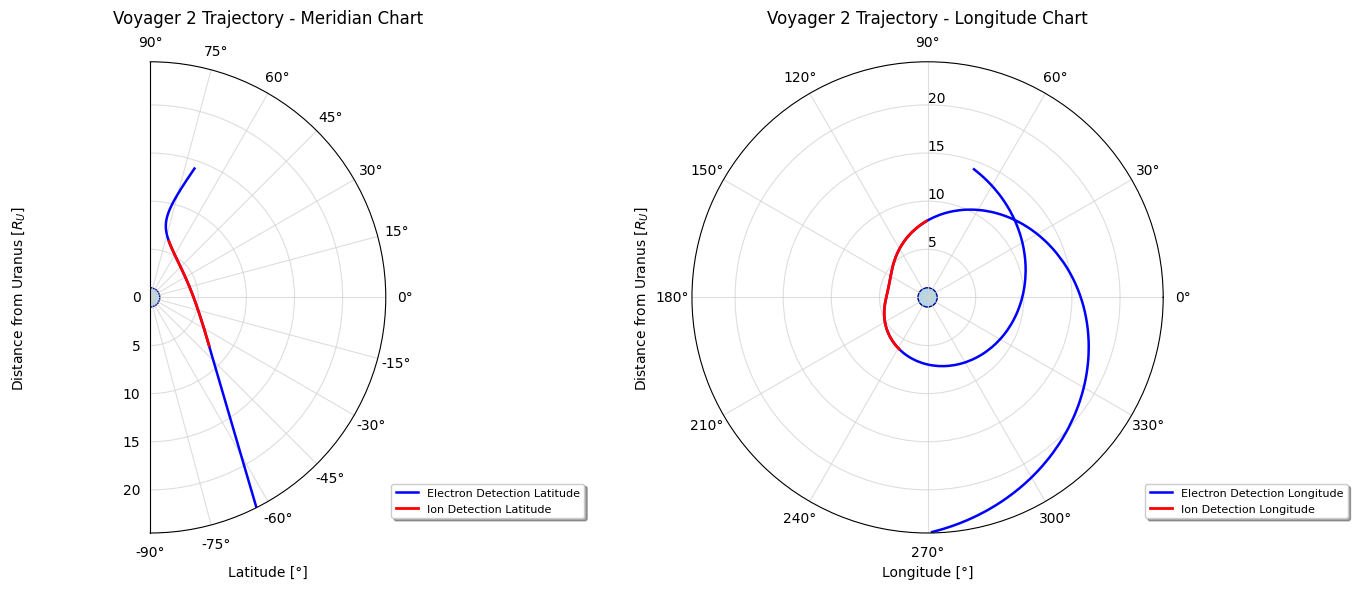

In [18]:
# Having completed the data processing phase, from this point forward all images necessary for enhanced interpretation 
# of the collected data are created:

# CHART 1: Representation of Satellite Trajectory and PLS Operational Segments
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Chart 1a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_electro['r'])+0.1)

# Electron Detection Latitude Representation
lat_electro_plot = np.radians((DF_electro['lat'])+90)
ax1.plot(lat_electro_plot, DF_electro['r'], color="blue", linewidth=1.8, label="Electron Detection Latitude")

# Ion Detection Latitude Representation
lat_ion_plot = np.radians((DF_ion['lat'])+90)
ax1.plot(lat_ion_plot, DF_ion['r'], color="red", linewidth=2, label="Ion Detection Latitude")

# Moons' Representation
#show_moon_lat(ax1,1)

# Circle with radius equal to 1 (Uranus representation)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Voyager 2 Trajectory - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_U$]')
ax1.legend(loc='lower left', bbox_to_anchor=(0.75, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Chart 1b: Longitude Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_electro['r'])+0.1)
ax2.set_rlabel_position(90)

# Electron Detection Longitude Representation
lon_electro_plot = np.radians(DF_electro['long'])
ax2.plot(lon_electro_plot, DF_electro['r'], color="blue", linewidth=1.8, label="Electron Detection Longitude")

# Ion Detection Longitude Representation
lon_ion_plot = np.radians((DF_ion['long']))
ax2.plot(lon_ion_plot, DF_ion['r'], color="red", linewidth=2, label="Ion Detection Longitude")

# Moons' Representation
#show_moon_long(ax2,1)

# Circle with radius equal to 1 (Uranus representation)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Voyager 2 Trajectory - Longitude Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_U$]', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Show full Chart
plt.tight_layout()
plt.show()

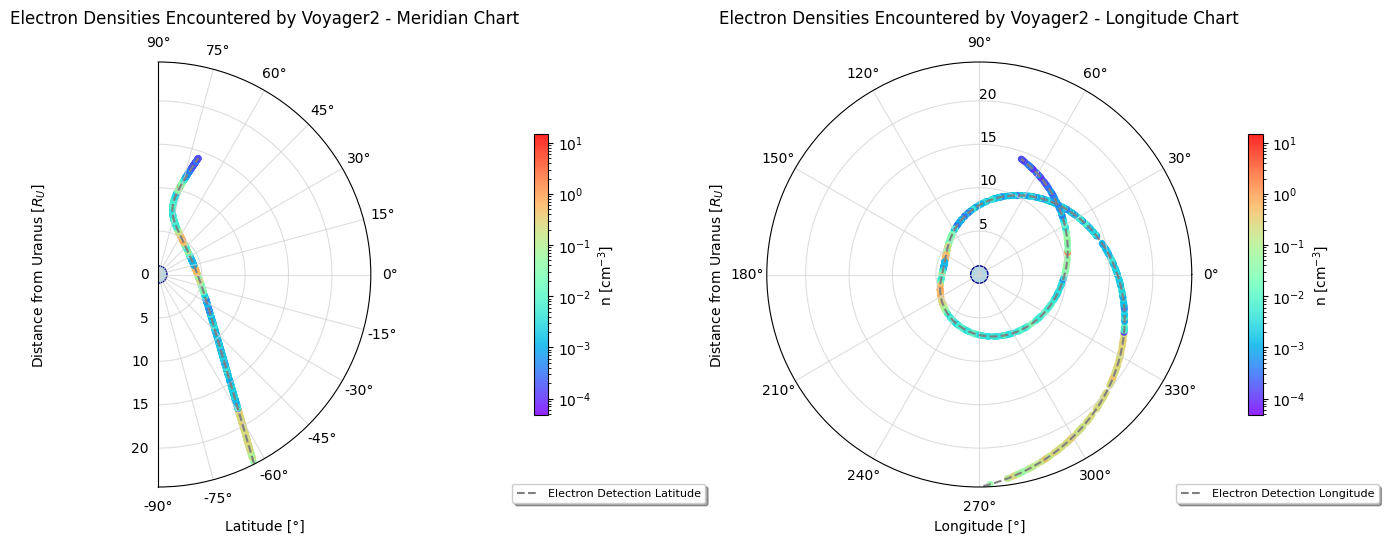

In [19]:
# CHART 2: Representation of Detected Total Electron Densities
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Chart 2a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_electro['r'])+0.1)

lat_electro_plot = np.radians((DF_electro['lat'])+90)
ax1.plot(lat_electro_plot, DF_electro['r'], color="grey", linewidth=1.5, linestyle='--', label="Electron Detection Latitude")
sc1=ax1.scatter(lat_electro_plot,DF_electro['r'],c=DF_electro['density total'],cmap='rainbow', norm=LogNorm(),s=15,alpha=0.85)

# Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# A logarithmic scale is implemented
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

# Moons' Representation:
#show_moon_lat(ax1,0)

# Circle with radius equal to 1 (Uranus representation)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Electron Densities Encountered by Voyager2 - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_U$]')
ax1.legend(bbox_to_anchor=(1.55, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Chart 2b: Longitude Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_electro['r'])+0.1)
ax2.set_rlabel_position(90)

lon_electro_plot = np.radians((DF_electro['long']))
ax2.plot(lon_electro_plot, DF_electro['r'], color="grey", linewidth=1.5, linestyle='--', label="Electron Detection Longitude")
sc2=ax2.scatter(lon_electro_plot, DF_electro['r'], c=DF_electro['density total'],cmap='rainbow',norm=LogNorm(),s=15,alpha=0.85)

# Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# A logarithmic scale is implemented
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

# Moons' Representation
#show_moon_long(ax2,1)

# Circle with radius equal to 1 (Uranus representation)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Electron Densities Encountered by Voyager2 - Longitude Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_U$]', labelpad=30)
ax2.legend(bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Show full Chart
plt.tight_layout()
plt.show()

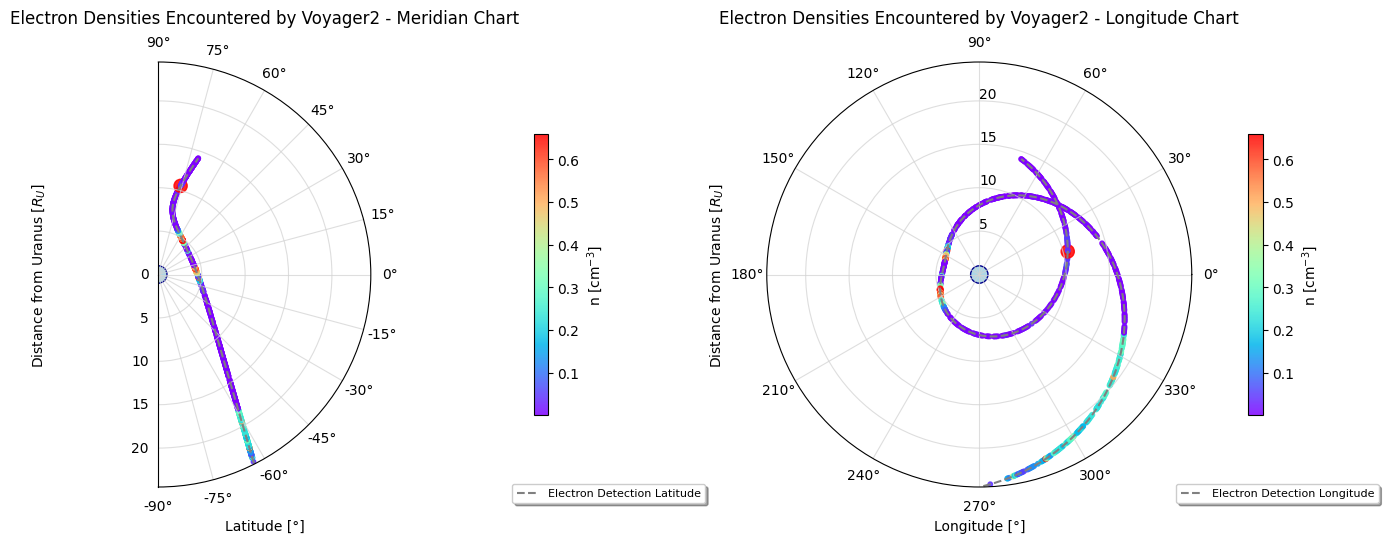

In [20]:
# CHART 2.1: Representation of Detected Total Electron Densities [LINEAR SCALE]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Chart 2.1a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_electro['r'])+0.1)

lat_electro_plot = np.radians((DF_electro['lat'])+90)
ax1.plot(lat_electro_plot, DF_electro['r'], color="grey", linewidth=1.5, linestyle='--', label="Electron Detection Latitude")

# Color normalization (extreme outliers that would compromise the representation are flattened in meaning and adjusted to extreme 
# colors of the scale):
norm=colors.Normalize(vmin=DF_electro["density total"].quantile(0.01),vmax=DF_electro["density total"].quantile(0.99))
# Marker size is rescaled proportionally to the possessed quantity:
sizes=(DF_electro['density total']/DF_electro['density total'].max())*80+10
# Scatter Representation
sc1=ax1.scatter(lat_electro_plot,DF_electro['r'],c=DF_electro['density total'],cmap='rainbow', norm=norm,s=sizes,alpha=0.85)

# Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile

# Moons' Representation:
#show_moon_lat(ax1,0)

# Circle with radius equal to 1 (Uranus representation)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Electron Densities Encountered by Voyager2 - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_U$]')
ax1.legend(bbox_to_anchor=(1.55, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Chart 2.1b: Longitude Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_electro['r'])+0.1)
ax2.set_rlabel_position(90)

lon_electro_plot = np.radians((DF_electro['long']))
ax2.plot(lon_electro_plot, DF_electro['r'], color="grey", linewidth=1.5, linestyle='--', label="Electron Detection Longitude")

# Color normalization (extreme outliers that would compromise the representation are flattened in meaning and adjusted to extreme 
# colors of the scale):
norm=colors.Normalize(vmin=DF_electro["density total"].quantile(0.01),vmax=DF_electro["density total"].quantile(0.99))
# Marker size is rescaled proportionally to the possessed quantity:
sizes=(DF_electro['density total']/DF_electro['density total'].max())*80+10
# Scatter Representation
sc2=ax2.scatter(lon_electro_plot, DF_electro['r'], c=DF_electro['density total'],cmap='rainbow',norm=norm,s=sizes,alpha=0.85)

# Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile

# Moons' Representation
#show_moon_long(ax2,1)

# Circle with radius equal to 1 (Uranus representation)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Electron Densities Encountered by Voyager2 - Longitude Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_U$]', labelpad=30)
ax2.legend(bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Show full Chart
plt.tight_layout()
plt.show()

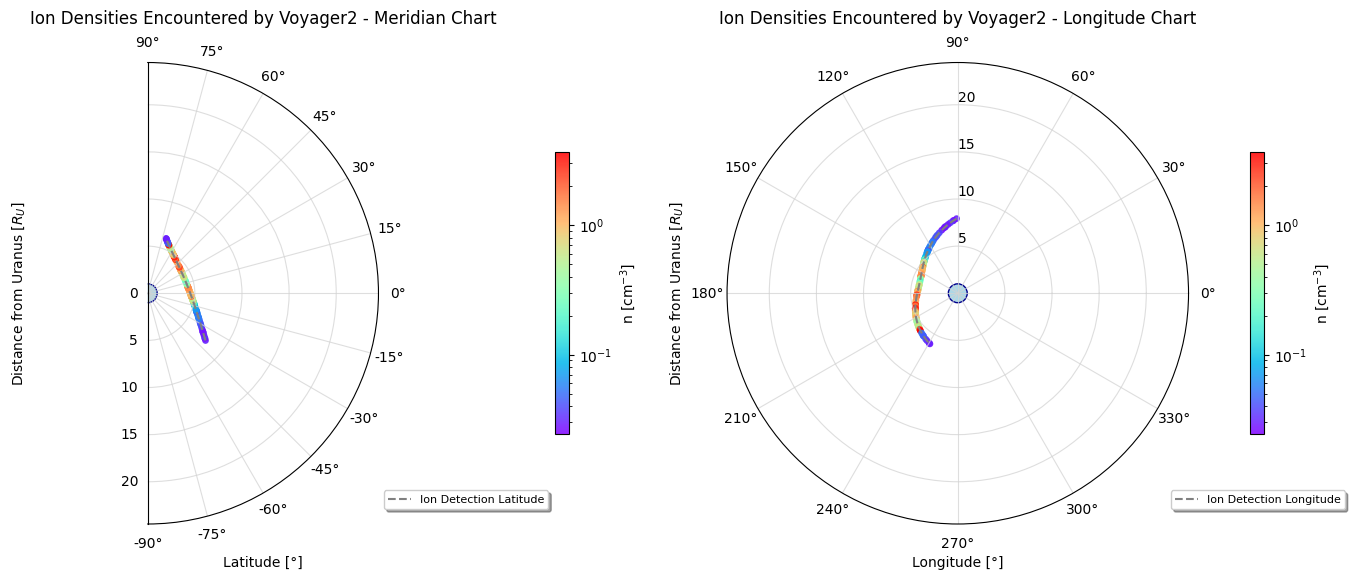

In [21]:
# Chart 3: Representation of Detected Total Ion Densities:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Chart 3a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_electro['r'])+0.1)

lat_ion_plot = np.radians((DF_ion['lat'])+90)
density_total_ion= DF_ion["density comp1"]+ DF_ion["density comp2"]+ DF_ion["density comp3"] # Calcolo la densità totale degli ioni sommando le densità delle singole componenti
ax1.plot(lat_ion_plot, DF_ion['r'], color="grey", linestyle='--', linewidth=1.5, label="Ion Detection Latitude")
sc1=ax1.scatter(lat_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=LogNorm(),s=15,alpha=0.85)

# Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# A logarithmic scale is implemented
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

# Moons' Representation:
#show_moon_lat(ax1,0)

# Circle with radius equal to 1 (Uranus representation)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Ion Densities Encountered by Voyager2 - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_U$]')
ax1.legend(loc='lower left', bbox_to_anchor=(0.75, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Chart 3b: Longitude Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_electro['r'])+0.1)
ax2.set_rlabel_position(90)

lon_ion_plot = np.radians((DF_ion['long']))
ax2.plot(lon_ion_plot, DF_ion['r'], color="grey", linestyle='--', linewidth=1.5, label="Ion Detection Longitude")
sc2=ax2.scatter(lon_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=LogNorm(),s=15,alpha=0.85)

# Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# A logarithmic scale is implemented
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

# Moons' Representation:
#show_moon_long(ax2,1)

# Circle with radius equal to 1 (Uranus representation)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Ion Densities Encountered by Voyager2 - Longitude Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_U$]', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Show full Chart
plt.tight_layout()
plt.show()

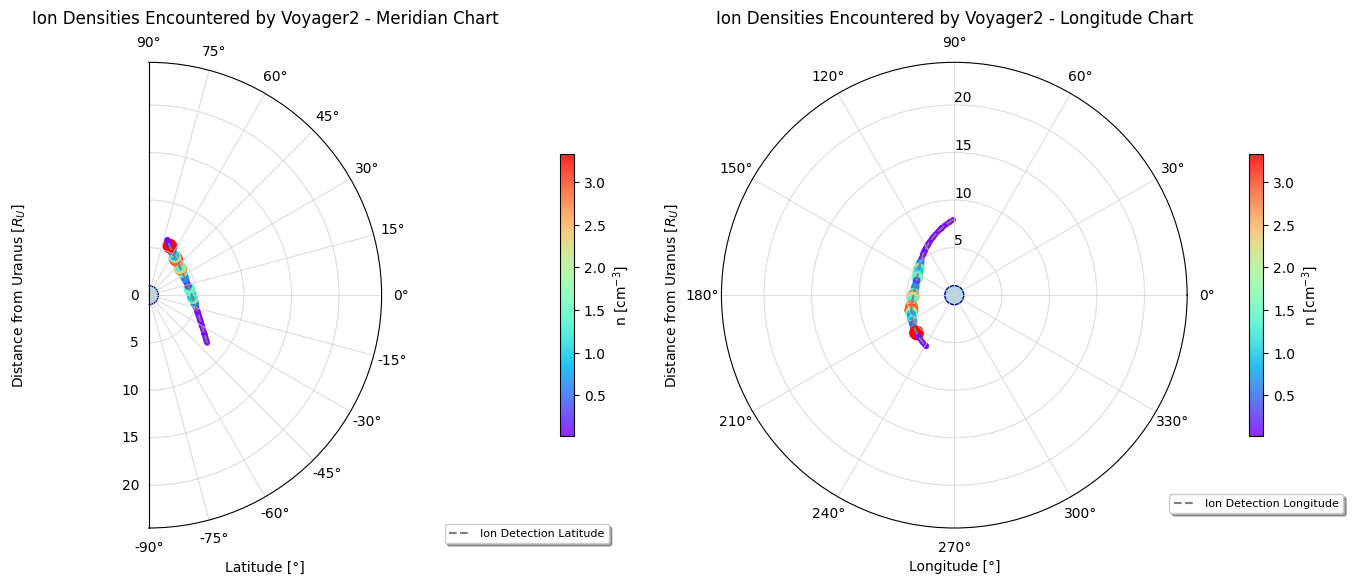

In [22]:
# CHART 3.1: Representation of Detected Total Ion Densities [LINEAR SCALE]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# CHART 3.1a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_electro['r'])+0.1)

lat_ion_plot = np.radians((DF_ion['lat'])+90)
density_total_ion= DF_ion["density comp1"]+ DF_ion["density comp2"]+ DF_ion["density comp3"] # Calcolo la densità totale degli ioni sommando le densità delle singole componenti
ax1.plot(lat_ion_plot, DF_ion['r'], color="grey", linestyle='--', linewidth=1.5, label="Ion Detection Latitude")

# Color normalization (extreme outliers that would compromise the representation are flattened in meaning and adjusted to extreme 
# colors of the scale):
norm=colors.Normalize(vmin=density_total_ion.quantile(0.01),vmax=density_total_ion.quantile(0.99))
# Marker size is rescaled proportionally to the possessed quantity:
sizes=(density_total_ion/density_total_ion.max())*80+10
# Scatter Representation
sc1=ax1.scatter(lat_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=norm,s=sizes,alpha=0.85)

# Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile

# Moons' Representation:
#show_moon_lat(ax1,0)

# Circle with radius equal to 1 (Uranus representation)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Ion Densities Encountered by Voyager2 - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_U$]')
ax1.legend(bbox_to_anchor=(1.25, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Chart 3.1b: Longitude Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_electro['r'])+0.1)
ax2.set_rlabel_position(90)

lon_ion_plot = np.radians((DF_ion['long']))
ax2.plot(lon_ion_plot, DF_ion['r'], color="grey", linestyle='--', linewidth=1.5, label="Ion Detection Longitude")
# Color normalization (extreme outliers that would compromise the representation are flattened in meaning and adjusted to extreme 
# colors of the scale):
norm=colors.Normalize(vmin=density_total_ion.quantile(0.01),vmax=density_total_ion.quantile(0.99))
# Marker size is rescaled proportionally to the possessed quantity:
sizes=(density_total_ion/density_total_ion.max())*80+10
# Scatter Representation
sc2=ax2.scatter(lon_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=norm,s=sizes,alpha=0.85)

# Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile

# Moons' Representation:
#show_moon_long(ax2,1)

# Circle with radius equal to 1 (Uranus representation)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Ion Densities Encountered by Voyager2 - Longitude Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_U$]', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Show full Chart
plt.tight_layout()
plt.show()

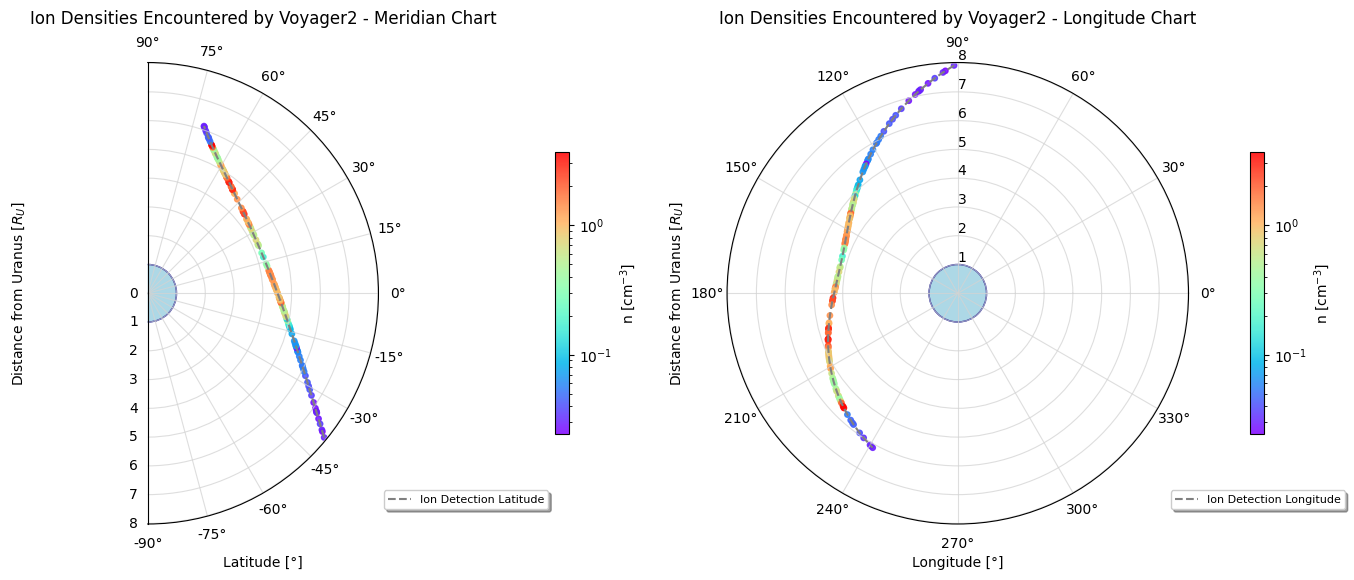

In [23]:
# CHART 3.2: Representation of Detected Total Ion Densities ZOOM:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Chart 3.2a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_ion['r'])+0.1)

lat_ion_plot = np.radians((DF_ion['lat'])+90)
density_total_ion= DF_ion["density comp1"]+ DF_ion["density comp2"]+ DF_ion["density comp3"] # Calcolo la densità totale degli ioni sommando le densità delle singole componenti
ax1.plot(lat_ion_plot, DF_ion['r'], color="grey", linestyle='--', linewidth=1.5, label="Ion Detection Latitude")
sc1=ax1.scatter(lat_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=LogNorm(),s=15,alpha=0.85)

# Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# A logarithmic scale is implemented
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

# Moons' Representation
'''# Dizionario con dataframe delle lune di Urano
satellites = {"Miranda": miranda, "Ariel":ariel}
# Dizionario con colori delle Lune (puro fattore estetico):
moon_colors = {"Miranda": "lightgray",   # superficie fratturata, chiaro
                    "Ariel": "silver"}        # più luminoso
for name, df in satellites.items():
    # Coordinate medie
    r_mean = df["r"].mean()
    lat_mean = np.radians(df["lat"].mean()+90)
    # Disegno la posizione della luna
    ax1.scatter(lat_mean, r_mean, color=moon_colors[name], edgecolor='black', s=40, label=name, zorder=3)'''

# Circle with radius equal to 1 (Uranus representation)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Ion Densities Encountered by Voyager2 - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_U$]')
ax1.legend(loc='lower left', bbox_to_anchor=(0.75, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Chart 3.1b: Longitude Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_ion['r'])+0.1)
ax2.set_rlabel_position(90)

lon_ion_plot = np.radians((DF_ion['long']))
ax2.plot(lon_ion_plot, DF_ion['r'], color="grey", linestyle='--', linewidth=1.5, label="Ion Detection Longitude")
sc2=ax2.scatter(lon_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=LogNorm(),s=15,alpha=0.85)

# Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# A logarithmic scale is implemented
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

#Rappresentazione Lune:
'''for name,df in satellites.items():
    r=df["r"]
    lon_moon_plot=np.radians(df["long"])
    # Disegno la traiettoria:
    ax2.plot(lon_moon_plot,r,color=moon_colors[name],linestyle=":",linewidth=1.5)
    # Posiziono il nome della luna in corrispondenza della media della sua orbita
    lon_mean = np.radians(df["long"].mean())   # angolo medio
    r_mean = r.mean()                          # raggio medio
    ax2.text(lon_mean, r_mean, name,
            color=moon_colors[name],
            fontsize=7, fontweight="bold",
            ha="center", va="bottom")'''

# Circle with radius equal to 1 (Uranus representation)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Ion Densities Encountered by Voyager2 - Longitude Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_U$]', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Show full Chart
plt.tight_layout()
plt.show()

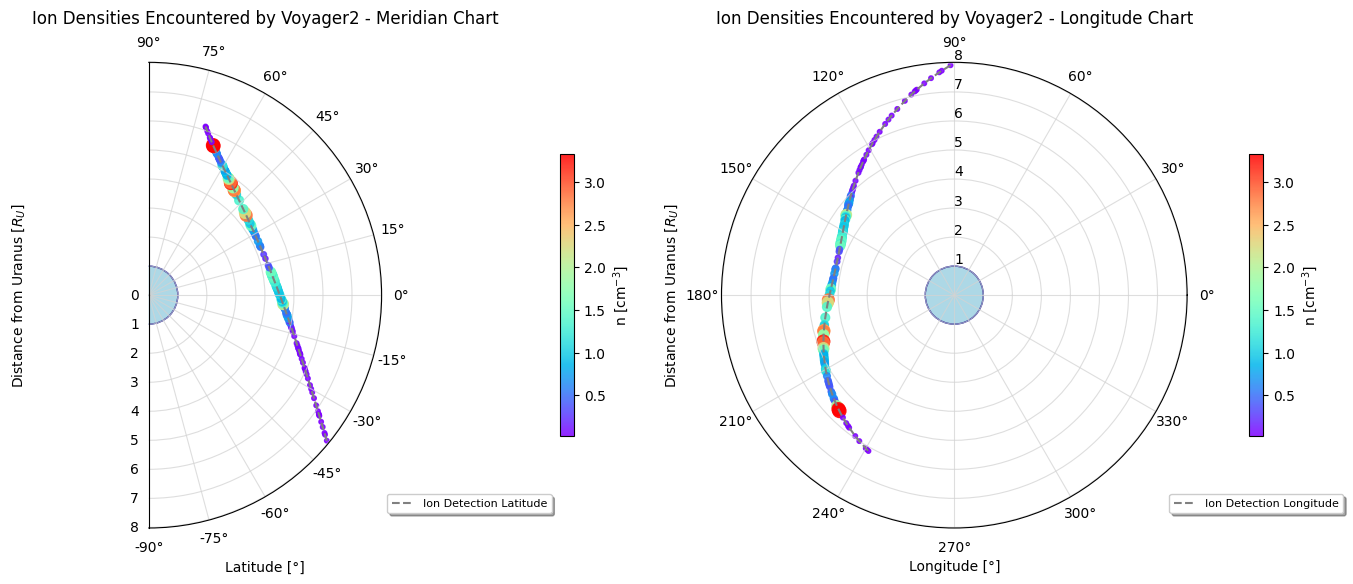

In [24]:
# Chart 3.3: Representation of Detected Total Ion Densities ZOOM [LINEAR SCALE]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Chart 3.3a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_ion['r'])+0.1)

lat_ion_plot = np.radians((DF_ion['lat'])+90)
density_total_ion= DF_ion["density comp1"]+ DF_ion["density comp2"]+ DF_ion["density comp3"] # Calcolo la densità totale degli ioni sommando le densità delle singole componenti
ax1.plot(lat_ion_plot, DF_ion['r'], color="grey", linestyle='--', linewidth=1.5, label="Ion Detection Latitude")
# Color normalization (extreme outliers that would compromise the representation are flattened in meaning and adjusted to extreme 
# colors of the scale):
norm=colors.Normalize(vmin=density_total_ion.quantile(0.01),vmax=density_total_ion.quantile(0.99))
# Marker size is rescaled proportionally to the possessed quantity:
sizes=(density_total_ion/density_total_ion.max())*80+10
# Scatter Representation
sc1=ax1.scatter(lat_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=norm,s=sizes,alpha=0.85)

# Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile

# Rappresentazione Lune:
'''# Dizionario con dataframe delle lune di Urano
satellites = {"Miranda": miranda, "Ariel":ariel}
# Dizionario con colori delle Lune (puro fattore estetico):
moon_colors = {"Miranda": "lightgray",   # superficie fratturata, chiaro
                    "Ariel": "silver"}        # più luminoso
for name, df in satellites.items():
    # Coordinate medie
    r_mean = df["r"].mean()
    lat_mean = np.radians(df["lat"].mean()+90)
    # Disegno la posizione della luna
    ax1.scatter(lat_mean, r_mean, color=moon_colors[name], edgecolor='black', s=40, label=name, zorder=3)
'''
# Circle with radius equal to 1 (Uranus representation)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Ion Densities Encountered by Voyager2 - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_U$]')
ax1.legend(loc='lower left', bbox_to_anchor=(0.75, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Chart 3.3b: Longitude Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_ion['r'])+0.1)
ax2.set_rlabel_position(90)

lon_ion_plot = np.radians((DF_ion['long']))
ax2.plot(lon_ion_plot, DF_ion['r'], color="grey", linestyle='--', linewidth=1.5, label="Ion Detection Longitude")
# Color normalization (extreme outliers that would compromise the representation are flattened in meaning and adjusted to extreme 
# colors of the scale):
norm=colors.Normalize(vmin=density_total_ion.quantile(0.01),vmax=density_total_ion.quantile(0.99))
# Marker size is rescaled proportionally to the possessed quantity:
sizes=(density_total_ion/density_total_ion.max())*80+10
# Scatter Representation
sc2=ax2.scatter(lon_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=norm,s=sizes,alpha=0.85)

# Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile

# Moons' Representation:
'''for name,df in satellites.items():
    r=df["r"]
    lon_moon_plot=np.radians(df["long"])
    # Trajectory Plot:
    ax2.plot(lon_moon_plot,r,color=moon_colors[name],linestyle=":",linewidth=1.5)
    # The moon's name is positioned at the mean location of its orbit
    lon_mean = np.radians(df["long"].mean())   # mean angle
    r_mean = r.mean()                          # mean radius
    ax2.text(lon_mean, r_mean, name,
            color=moon_colors[name],
            fontsize=7, fontweight="bold",
            ha="center", va="bottom")'''


# Circle with radius equal to 1 (Uranus representation)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Ion Densities Encountered by Voyager2 - Longitude Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_U$]', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Show full Chart
plt.tight_layout()
plt.show()

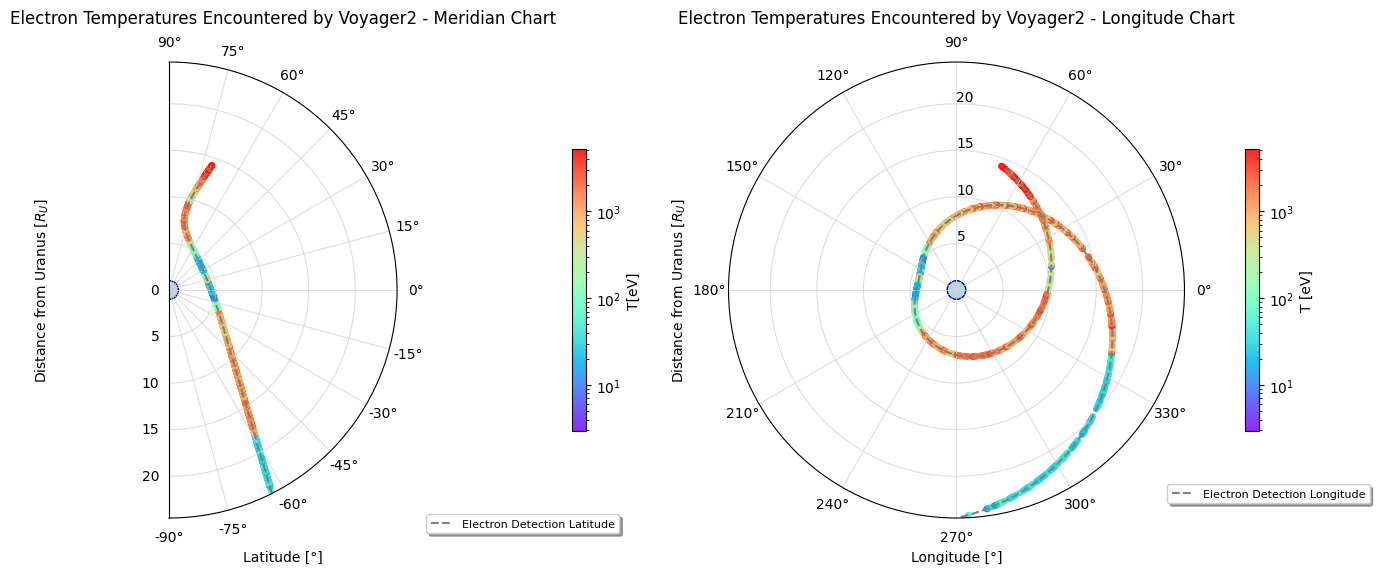

In [25]:
# Chart 4: Representation of Total Electron Temperatures:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Chart 4a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_electro['r'])+0.1)

lat_electro_plot = np.radians((DF_electro['lat'])+90)
ax1.plot(lat_electro_plot, DF_electro['r'], color="grey", linewidth=1.5, linestyle='--', label="Electron Detection Latitude")
sc1=ax1.scatter(lat_electro_plot,DF_electro['r'],c=DF_electro['temperature total'],cmap='rainbow', norm=LogNorm(),s=15,alpha=0.85)

# Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("T[eV]")  # etichetta della variabile
# A logarithmic scale is implemented
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

# Moons' Representation:
#show_moon_lat(ax1,0)

# Circle with radius equal to 1 (Uranus representation)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Electron Temperatures Encountered by Voyager2 - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_U$]')
ax1.legend(bbox_to_anchor=(1.25, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Chart 4b: Longitude Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_electro['r'])+0.1)
ax2.set_rlabel_position(90)


lon_electro_plot = np.radians((DF_electro['long']))
ax2.plot(lon_electro_plot, DF_electro['r'], color="grey", linewidth=1.5, linestyle='--', label="Electron Detection Longitude")
sc2=ax2.scatter(lon_electro_plot, DF_electro['r'], c=DF_electro['temperature total'],cmap='rainbow',norm=LogNorm(),s=15,alpha=0.85)

# Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("T [eV]")  # etichetta della variabile
# A logarithmic scale is implemented
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

# Moons' Representation:
#show_moon_long(ax2,1)

# Circle with radius equal to 1 (Uranus representation)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Electron Temperatures Encountered by Voyager2 - Longitude Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_U$]', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Show full Chart
plt.tight_layout()
plt.show()

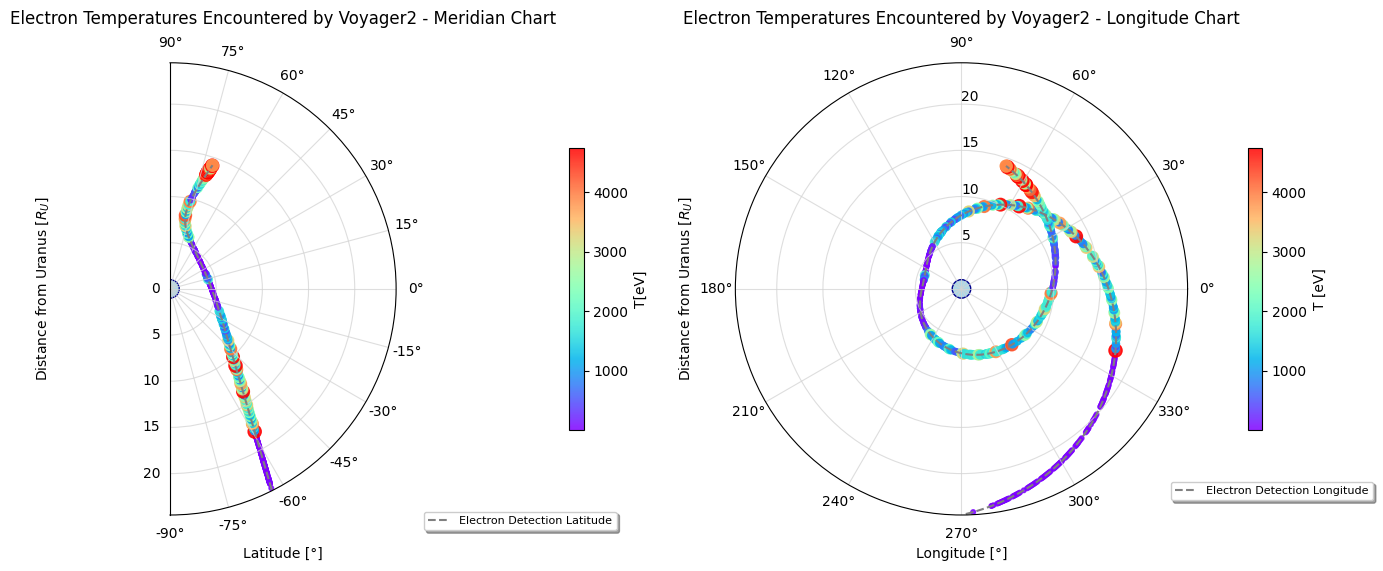

In [26]:
# Chart 4.1: Representation of Total Electron Temperatures [LINEAR SCALE]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Chart 4.1a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_electro['r'])+0.1)

lat_electro_plot = np.radians((DF_electro['lat'])+90)
ax1.plot(lat_electro_plot, DF_electro['r'], color="grey", linewidth=1.5, linestyle='--', label="Electron Detection Latitude")
# Color normalization (extreme outliers that would compromise the representation are flattened in meaning and adjusted to extreme 
# colors of the scale):
norm=colors.Normalize(vmin=DF_electro['temperature total'].quantile(0.01),vmax=DF_electro['temperature total'].quantile(0.99))
# Marker size is rescaled proportionally to the possessed quantity:
sizes=(DF_electro['temperature total']/DF_electro['temperature total'].max())*80+10
# Scatter Representation
sc1=ax1.scatter(lat_electro_plot,DF_electro['r'],c=DF_electro['temperature total'],cmap='rainbow', norm=norm,s=sizes,alpha=0.85)

# Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("T[eV]")  # etichetta della variabile

# Moons' Representation:
#show_moon_lat(ax1,0)

# Circle with radius equal to 1 (Uranus representation)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Electron Temperatures Encountered by Voyager2 - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_U$]')
ax1.legend(bbox_to_anchor=(1.25, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Chart 4.1b: Longitude Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_electro['r'])+0.1)
ax2.set_rlabel_position(90)

lon_electro_plot = np.radians((DF_electro['long']))
ax2.plot(lon_electro_plot, DF_electro['r'], color="grey", linewidth=1.5, linestyle='--', label="Electron Detection Longitude")
# Color normalization (extreme outliers that would compromise the representation are flattened in meaning and adjusted to extreme 
# colors of the scale):
norm=colors.Normalize(vmin=DF_electro['temperature total'].quantile(0.01),vmax=DF_electro['temperature total'].quantile(0.99))
# Marker size is rescaled proportionally to the possessed quantity:
sizes=(DF_electro['temperature total']/DF_electro['temperature total'].max())*80+10
# Scatter Representation
sc2=ax2.scatter(lon_electro_plot, DF_electro['r'], c=DF_electro['temperature total'],cmap='rainbow',norm=norm,s=sizes,alpha=0.85)

# Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("T [eV]")  # etichetta della variabile

# Moons' Representation:
#show_moon_long(ax2,1)

# Circle with radius equal to 1 (Uranus representation)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Electron Temperatures Encountered by Voyager2 - Longitude Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_U$]', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Show full Chart
plt.tight_layout()
plt.show()

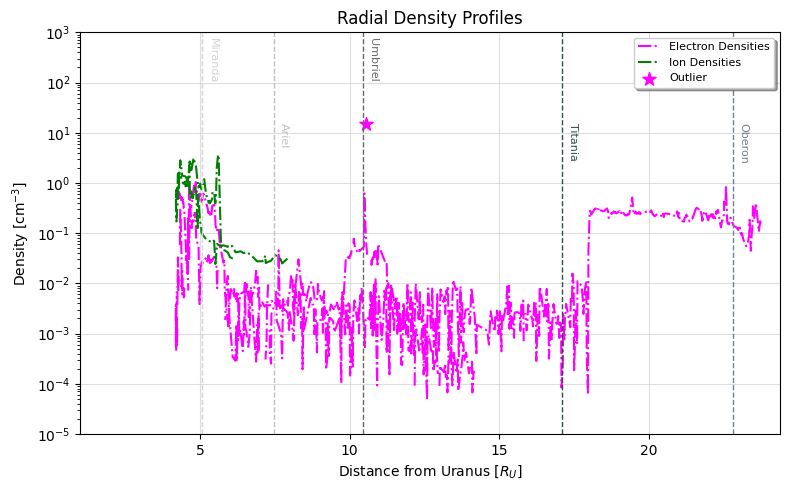

In [27]:
# Chart 5: Representation of Total Detected Ion and Electron Density in Relation to Uranus Radial Distance 
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111) # This 111 specifies to the program that a single plotting area is desired (1 row, 1 column, 1st plot)

# Graphical Representation of Data
# In the case of electron measurements, a "disturbance" value of "15.05" is present; according to personal assessment,
# this is considered an erroneous value as it lacks coherence with data collected both previously and subsequently;
# it is therefore initially excluded from the following figure to achieve improved visualization through mask utilization:
# Create the mask: True for all values DIFFERENT from the maximum
maschera = DF_electro['density total'] != DF_electro['density total'].max()

# The mask will have:
# - True for all values ≠ max_value
# - False only for the maximum value

# Electron Densities:
ax.plot(DF_electro['r'][maschera], DF_electro['density total'][maschera], color='magenta', linewidth=1.5, linestyle='-.', label="Electron Densities")
# Ion Densities:
ax.plot(DF_ion['r'], density_total_ion, color='green', linewidth=1.5, linestyle='-.', label="Ion Densities")

# For comprehensive representation, the value previously labeled as "disturbance" is included. 
# To achieve an aesthetically pleasing visualization, the data is presented in logarithmic form:
max_density_value=DF_electro["density total"].max()
id_max_density=DF_electro["density total"].idxmax()
r_max_density = DF_electro.loc[id_max_density, "r"]
# Linear Scale Version
#ax.scatter(r_max_density, np.log10(max_density_value), color='red', marker='*', s=80, label="Outlier (log10)")
#ax.annotate(f"density={max_density_value:.2f}[$cm^-3$] \n radial distance={r_max_density:.2f}[$R_u$]",
#            xy=(r_max_density, np.log10(max_density_value)),
#            xytext=(+20, +20),  # offset del testo rispetto al punto
#            textcoords="offset points",
#            arrowprops=dict(arrowstyle="->", color="black"),
#            fontsize=8, backgroundcolor="white")

# Logarithmic Scale Version
ax.scatter(r_max_density, max_density_value, color='magenta', marker='*', s=100, label="Outlier")
#ax.annotate(f"density={max_density_value:.2f}[$cm^-3$] \n radial distance={r_max_density:.2f}[$R_u$]",
#            xy=(r_max_density, max_density_value),
#            xytext=(+20, +20),
#            textcoords="offset points",
#            arrowprops=dict(arrowstyle="->", color="black"),
#            fontsize=8, backgroundcolor="white")

# Moons' Representation
show_moon_cart(ax)

# Axis Settings and Visualization: 
ax.set_xlim(1,max(DF_electro['r'][maschera]))
# Modify here to change from a logarithmic version to a linear version:
ax.set_ylim(1e-5,1e3)
ax.set_yscale('log') # Remove here
# -------------------------------------------------------------------------
ax.set(xlabel='Distance from Uranus [$R_U$]',ylabel='Density [cm$^{-3}$]')
ax.set_title('Radial Density Profiles')
ax.grid(color='lightgray',alpha=0.75)
# Adds Miranda label in Chart
ax.text(miranda['r'].mean()+0.35, ax.get_ylim()[1] * 0.78,   # posizione leggermente sotto il bordo superiore
            'Miranda',
            color='lightgray',
            fontsize=8,
            ha='center', va='top',
            rotation=270)
# Adds Umbriel label in Chart
ax.text(umbriel['r'].mean()+0.35, ax.get_ylim()[1] * 0.78,   # posizione leggermente sotto il bordo superiore
            'Umbriel',
            color='dimgray',
            fontsize=8,
            ha='center', va='top',
            rotation=270)
# Adds Oberon label in Chart
ax.text(oberon['r'].mean()+0.35, ax.get_ylim()[1] * 0.68,   # posizione leggermente sotto il bordo superiore
            'Oberon',
            color='slategray',
            fontsize=8,
            ha='center', va='top',
            rotation=270)
# Adds legend
ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True, fontsize=8)
# Show full Chart
plt.tight_layout()
plt.show()

In [28]:
# Helper function for acos with safety
def acos(x):
    return np.arccos(np.clip(x, -1.0, 1.0))

# Having produced all necessary graphical representations, an autonomous function called cartesian_to_magnetic_uranus is now developed.
# Given geographic position values for a specific point as input, it has to return the corresponding magnetic coordinates according to OTD model. 
# The objective is to compute the magnetic latitude for each point along Voyager 2's trajectory during the Uranus flyby:

def cartesian_to_magnetic_uranus(x_iau, y_iau, z_iau):
    """
    Convert IAU Uranus cartesian coordinates to magnetic coordinates using OTD model.
    
    -----------
    Parameters:
    -----------
    x_iau, y_iau, z_iau : float or array-like
        Cartesian coordinates in IAU Uranus frame (planet-centered)
    
    --------
    Returns:
    --------
    dict with arrays of:
        magnetic_latitude : float (degrees, -90 to +90)
        magnetic_colatitude : float (degrees, 0 to 180)
    """
    
    # OTD parameters from Ness et al. (1986)
    DIPOLE_TILT = np.radians(60.0)
    
    POLE_LAT = np.radians(15.2)
    POLE_LON = np.radians(360 - 47.7)
    
    # Magnetic pole unit vector in IAU coordinates
    mag_pole_x = np.cos(POLE_LAT) * np.cos(POLE_LON)
    mag_pole_y = np.cos(POLE_LAT) * np.sin(POLE_LON)
    mag_pole_z = np.sin(POLE_LAT)
    
    # Dipole offset parameters (in planetary radii)
    DIPOLE_OFFSET_X = -0.02
    DIPOLE_OFFSET_Y = 0.02  
    DIPOLE_OFFSET_Z = -0.31
    
    # Apply dipole offset: shift coordinates to dipole-centered system
    x_offset = x_iau - DIPOLE_OFFSET_X
    y_offset = y_iau - DIPOLE_OFFSET_Y
    z_offset = z_iau - DIPOLE_OFFSET_Z
    
    # Calculate position vector magnitude (distance from dipole center)
    # Usa np.sqrt invece di math.sqrt per gestire array
    r_mag = np.sqrt(x_offset**2 + y_offset**2 + z_offset**2)
    
    # Normalize position vector
    # Crea array di default per quando r_mag = 0
    x_norm = np.zeros_like(x_offset)
    y_norm = np.zeros_like(y_offset)
    z_norm = np.zeros_like(z_offset)
    
    # Applica la normalizzazione solo dove r_mag > 0
    mask = r_mag > 0
    x_norm[mask] = x_offset[mask] / r_mag[mask]
    y_norm[mask] = y_offset[mask] / r_mag[mask]
    z_norm[mask] = z_offset[mask] / r_mag[mask]
    
    # Calculate magnetic latitude using dot product with pole direction
    cos_colat = (x_norm * mag_pole_x + 
                 y_norm * mag_pole_y + 
                 z_norm * mag_pole_z)
    
    # Ensure numerical stability
    cos_colat = np.clip(cos_colat, -1.0, 1.0)
    
    # Calculate magnetic colatitude (angle from magnetic pole)
    magnetic_colat_rad = acos(cos_colat)
    
    # Calculate magnetic latitude (90° - colatitude)
    magnetic_lat_rad = np.pi/2 - magnetic_colat_rad
    magnetic_latitude = np.degrees(magnetic_lat_rad)
    
    return {
        'magnetic_latitude': magnetic_latitude,
        'magnetic_colatitude': np.degrees(magnetic_colat_rad),
        'distance_from_dipole': r_mag
    }

# Utilize the function to integrate the acquired data into the existing dataframes:
# Electron Dataframe
x,y,z = DF_electro['pos_x'], DF_electro['pos_y'], DF_electro['pos_z']
mlat_DF = cartesian_to_magnetic_uranus(x,y,z)
mlat_DF=pd.DataFrame.from_dict(mlat_DF)
DF_electro=DF_electro.join(mlat_DF)
# Ion Dataframe
x,y,z = DF_ion['pos_x'], DF_ion['pos_y'], DF_ion['pos_z']
mlat_DF = cartesian_to_magnetic_uranus(x,y,z)
mlat_DF=pd.DataFrame.from_dict(mlat_DF)
DF_ion=DF_ion.join(mlat_DF)
del x,y,z

In [29]:
# The function used to represent Moons in Meridian Charts is modified to adapt it for magnetic latitude utilization:
def show_moon_mlat(subplot):
    """
    Plot Uranian moon trajectories in magnetic latitude coordinates.
    
    Visualizes moon orbital paths in the Uranian magnetic coordinate system,
    converting from IAU Uranus frame to magnetic coordinates using the OTD model.
    Displays complete trajectories with moon positions and alternating labels.
    
    Parameters
    ----------
    subplot : matplotlib.axes.Axes
        Matplotlib subplot axis for magnetic coordinate visualization
        
    Notes
    -----
    Uses cartesian_to_magnetic_uranus function for coordinate transformation
    Magnetic latitude converted to radians with +90° offset for polar plotting
    Moon trajectories shown as dotted lines with mean positions as scatter points
    Label positioning alternates above/below to minimize overlap
    Color scheme consistent with geological and albedo characteristics
    """
    # Dictionary with Uranus moon DataFrames
    satellites = {
        "Miranda": miranda, 
        "Ariel": ariel, 
        "Umbriel": umbriel, 
        "Titania": titania, 
        "Oberon": oberon
    }
    
    # Moon color dictionary (aesthetic selection based on surface properties)
    moon_colors = {
        "Miranda": "lightgray",    # Fractured surface, bright appearance
        "Ariel": "silver",         # Highest albedo, brightest moon
        "Umbriel": "dimgray",      # Lowest albedo, darkest moon
        "Titania": "darkslategray",
        "Oberon": "slategray"
    }
    
    for i, (name, df) in enumerate(satellites.items()):
        # Convert from IAU Uranus to magnetic coordinates using OTD model
        x_iau, y_iau, z_iau = df['pos_x'], df['pos_y'], df['pos_z']
        df_mag = cartesian_to_magnetic_uranus(x_iau, y_iau, z_iau)
        df_mag = pd.DataFrame.from_dict(df_mag)
        
        # Extract variables for magnetic coordinate plotting
        mlat_plot_moon = np.radians(df_mag['magnetic_latitude'] + 90)
        
        # Plot moon trajectory in magnetic coordinates
        subplot.plot(mlat_plot_moon, df_mag['distance_from_dipole'], 
                    color=moon_colors[name], linewidth=1.8, linestyle=':')
        
        # Calculate mean position for moon labeling
        mid_mlat = mlat_plot_moon.mean()
        mid_rad = df_mag['distance_from_dipole'].mean()
        
        # Plot moon position as scatter point
        subplot.scatter(mid_mlat, mid_rad, color=moon_colors[name], 
                       edgecolor='black', s=40, zorder=3)
        
        # Add moon names with alternating label positions
        if i % 2 == 0:  
            # Label above trajectory
            subplot.text(mid_mlat + np.radians(25), mid_rad + 0.5, name,
                        color=moon_colors[name],
                        fontsize=9, fontweight="bold",
                        ha="center", va="bottom")
        else:
            # Label below trajectory  
            subplot.text(mid_mlat - np.radians(15), mid_rad - 0.5, name,
                        color=moon_colors[name],
                        fontsize=9, fontweight="bold",
                        ha="center", va="top")
        

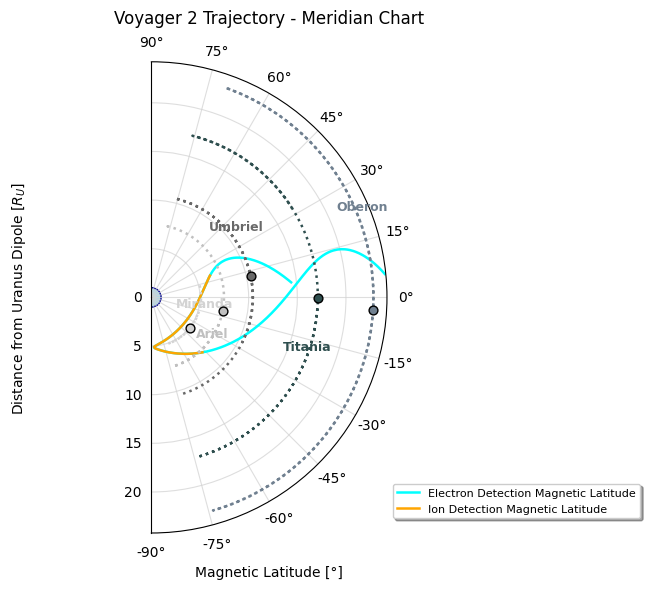

In [30]:
# Having obtained an estimate of the magnetic latitude observed by Voyager 2 during the FlyBy, a representation is provided 
# through the use of an appropriately modified Meridian Chart:
# Chart 6: Representation of Satellite Trajectory and PLS Operational Segments [Magnetic Latitude VERSION]
fig, (ax1) = plt.subplots(1, 1, subplot_kw={'polar': True}, figsize=(14,6))

# Chart 6a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_electro['distance_from_dipole'])+0.1)

# Voyager 2 Magnetic Latitude Representation
mlat_ele_plot = np.radians(DF_electro['magnetic_latitude']+90)
ax1.plot(mlat_ele_plot, DF_electro['distance_from_dipole'], color="cyan", linewidth=1.8, label="Electron Detection Magnetic Latitude")
mlat_ion_plot = np.radians(DF_ion['magnetic_latitude']+90)
ax1.plot(mlat_ion_plot, DF_ion['distance_from_dipole'], color="orange", linewidth=1.8, label="Ion Detection Magnetic Latitude")


# Moons' Representation
show_moon_mlat(ax1)

# Circle with radius equal to 1 (Uranus representation)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Voyager 2 Trajectory - Meridian Chart', va='bottom')
ax1.set_xlabel('Magnetic Latitude [°]')
ax1.set_ylabel('Distance from Uranus Dipole [$R_U$]')
ax1.legend(loc='lower left', bbox_to_anchor=(0.75, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Show full Chart
plt.tight_layout()
plt.show()